# Genome-scale metabolic model reconstruction

By Haris Zafeiropoulos -- December, 2024
Based on a previous version: By Daniel Garza and Haris Zafeiropoulos -- December, 2022

Slides accompanying this notebook can be found [here](https://docs.google.com/presentation/d/1j9GY6BSPFH1pjL0NsNDONkUx8l1XgjUhnmAJKok3MmE/edit?usp=sharing).

## About this notebook

Aim of this notebook is to allow you to go through the basic concepts of metabolic model reconstruction and their analysis. 

An example application will be then performed. 

To this end, you will implement some Python code we have written for you that you may find under the `scripts/` folder. 

Almost all you are about to go through is based on the [`cobrapy`](https://opencobra.github.io/cobrapy/) Python library. 
Please, make sure you have a working `cobrapy` version of `cobrapy` set. 

You can run 

    conda create -n met_class python=3.10 --no-default-packages
    conda activate met_class
    pip install -r requirements

to make sure you have all required. 


In case your jupyter does not line with the `met_class` environment, you may give it a shot after running:

In [ ]:
import sys
import os
env_site_packages = os.path.join(os.getenv('CONDA_PREFIX'), 'lib/python3.10/site-packages')  # Adjust for your Python version
if env_site_packages not in sys.path:
    sys.path.append(env_site_packages)

> **The extra mile**
> 
> Remember that this notebook builds a toy example. If you are about to work with an actual GEM, you most probably need to install a "solver"; 
> software designed to efficiently find solutions to mathematical optimization problems. 
> There are several solvers, both commercial and open-source. 
> Most common commercial ones are [Gurobi](https://www.gurobi.com) and [CPLEX](https://www.ibm.com/products/ilog-cplex-optimization-studio), while a really nice one (in my opinion) open-source is [HiGHS](https://highs.dev)
> Gurobi and HIGHS can be both implemented through the [PyOptInterface](https://metab0t.github.io/PyOptInterface/) library that builds a unified API to construct and solve optimization models.

In this repo, you can find toy models for three human gut species that occupy important ecological niches in the gut and are known to metabolically interact with one another as in the following diagram:

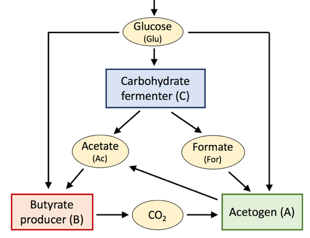

These ecological niches are based on the metabolism of the following three species:

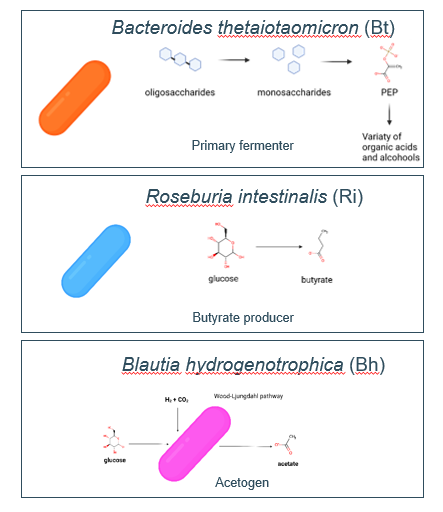

During this class we will work only with the first of them, Bt. 
However, feel free to play around with the other two, why not compare their features and more! 

## GEM reconstruction introduction

There are several software solutions these days to come up with Genome-scale metabolic models (GEMs); always starting from a genome. 
A GEM may consist of thousands metabolites and reactions. 
To make this introduction as straight-forward as possible, we will skip the GEM challenges, and we will use toy models, that they yet have the basic characteristics of any constraint-based model. 
To this end, we will build 1 (out of 3) custom models of our own, as described in [Garza et *al.* (2023)](https://doi.org/10.1016/j.cels.2022.11.002) 
We will also use the core model *E. coli*.

In case you cannot make everything on time, that's ok!
You can use the models that are already reconstructed, which are available in the folder.
All 4 models are available under [`files/models`](files/models/).
By just running the chunks of this notebook, you will have the answers to the questions asked along the notebook. 

Let us first load the libraries required for this notebook.

In [ ]:
# Libraries
import cobra
import numpy as np
import pandas as pd 

# Local scripts
from scripts.intro import samples_in_constraint_3D
from scripts.utils import apply_environment

To solve the optimization problems in our model, a solver is required; special software that can solve a wide range of problem types, such as linear programming, mixed-integer linear programming, quadratic programming, mixed-integer quadratic programming etc.
These problems are rather common in metabolic modelling and most of the analyses performed in the field, are based on solivng such optimization problems.

`cobra` uses by default the [Gurobi](https://www.gurobi.com) solver. This solver requires a paid license, but can also [be obtained](https://www.gurobi.com/downloads/) for free under an [academic license](https://www.gurobi.com/downloads/end-user-license-agreement-academic/).

To avoid the need to install Gurobi and set up an academic license, we will use the free `glpk` solver that is already installed when one install `cobrapy`:

In [ ]:
cobra_config = cobra.Configuration()
cobra_config.solver = 'glpk'

And let's have a look on a `cobra` model's basic parts

### Build from scratch

In [ ]:
model = cobra.Model()
model

A `cobra.Model` is a `class`, meaning we can *edit* its features on the fly. 

> [**Reminder**] A Python class is a ***blueprint*** for creating ***objects*** (instances). It defines a set of ***attributes*** (data) and ***methods*** (functions) that the objects created from the class will have.

For example, we can give it a name:

In [ ]:
model.id = "metModelClass"
model

You notice the difference? 

As you can see, our model is empty, meaning **no metabolites**, **no reactions** are there.

Assume now we have annotated the genome of the strain of interest (in our case a sugar fermenter, pseudo-*Bacteroides thetaiotaomicron*) and we have a list of the reactions it can go for. 

> **Note**
>
> ***Fermentation*** and ***respiration*** are the two major processes aiming at
> generate ATP for cellular functions and for both the first step is glycolysis, i.e. the breakdown of glucose (or other sugars) into pyruvate.
> Their key difference focuses on whether they involve an **Electron Transport Chain** (respiration) or not (fermentation).
> Respiration, when aerobic, ends up producing $CO{_2}$ and $H{_2}0$, while fermentation organic acids (e.g. lactate) or alcohol (e.g., ethanol) and $CO_{2}$.
> Last, respiration can reach up to much higher ATP yield, i.e. ATP molecules per glucose.


In [ ]:
genome_reactions = pd.read_csv("files/BT_metabolicReactions.txt", sep="\t") 
genome_reactions.head()

The first two columns of this file stand for two ids, `BiGG` and `SEED`; 
these columns represent the two most widely used ontologies in metabolic modeling: 
- [BiGG](http://bigg.ucsd.edu) models focused on providing GEMs for well-studied organisms.
- [ModelSEED](https://modelseed.org) models focus on automating metabolic model reconstruction for a wide range of organisms, including those with limited genomic and biochemical data.

For this class, we are going to use the ModelSEED universe.

The following two columns provide the name and the stoichiometry of the reaction.
For example, for `rxn05573` we see that:

    D-Glucose[1] + H+[1] <=> D-Glucose + H+


The number of molecules used of each compound is denoted in the brackets. 
Importantly, the **directionality** of the reaction is mentioned with the double arrow. 

Those two columns, even informative for us in the first view, they are not really necessary!
And this is because of the ontology being used. 
As mentioned, we use ModelSEED; once we mention the reaction id, ModelSEED has a specific description of the reaction which you can see in the [`reactions.tsv`](./files/biochemistry/reactions.tsv) under the [`files/biochemistry`](./files/biochemistry/) folder.


We will skip going through all the features describing the reaction for the sake of time, but **remember** that the stoichiometry, the reversibility and whether the reaction is transport or not, they all come as features of the reaction. 

> Also, any ideas about what the `pathways` column may stand for ?
> Example:
>
> rxn00001 ~~ MetaCyc: Degradation (Degradation/Utilization/Assimilation); Glyphosate-Degradation (glyphosate degradation); Noncarbon-Nutrients (Inorganic Nutrient Metabolism); PWY-7805 ((aminomethyl)phosphonate degradation); PWY-7807 (glyphosate degradation III); Phosphorus-Compounds (Phosphorus Compound Metabolism)

Looking at the `genome_reactions` data frame once more, do you notice the `exchange` column?

In [ ]:
genome_reactions[genome_reactions["exchange"].notna()]

*Exchange* reactions are a type of **boundary reactions**.
There are three different types of pre-defined **boundary reactions**. 
All of them are **unbalanced pseudo reactions**, that means they fulfill a function for modeling by **adding to or removing metabolites** from the model system but are **not based on real biolog**y. These reaction types include:

* **exchange:** reversible reactions that add to or remove an extracellular metabolite from the extracellular compartment 
* **demand:** irreversible reaction that each consumes an intracellular metabolite. 
* **sink** is similar to an exchange but specifically for intracellular metabolites, i.e., a reversible reaction that adds or removes an intracellular metabolite.

But if there are boundary reactions, that means that our model should have different ***compartments***.
So, here's what's going on:

![open_closed_systems](./files/figs/comp.png)


Actually, if we have a look in the `cobra.Model` instance of ours, we'll notice that last line stands for compartments, that currently, are also empty.

-------

Do you remember the matrix notion from the slides? 

The $S$ matrix represents the **stoichiometric matrix** where *metabolites* are represented in its *rows*, and *reactions* in its *columns*.


$S_{int}$ describes the **internal** reactions and their compounds, in this example case that would be a single reaction ($v_1$) that requires one molecule of A and B to produce one molecule of C.

On the other hand, $S_{exch}$ includes also the exchange reactions, **but not the external metabolites**. Thus, A and B can be uptaken through $b{_1}$ and $b{_2}$ while C can be secreted thanks to $b{_3}$.

-------

So, let us now ***build*** a metabolic model of our own, i.e., no software dedicated to automated reconstructions will be used. 

On the contrary, we will use the [`build_bt_model.py`](scripts/build_bt_model.py) by Daniel Garza.

This script uses instances of two key classes, called `Compounds` and `Reactions`, which you may find in the `MSEED_compounds.py` and `MSEED_reactions.py` scripts correspondingly. We will not go through those during the class for the sake of time, but feel free to go through them, and we can discuss at a later point. 

The key concept of those two classes is to enable parsing the ModelSEED files for compounds and reactions as the `reactions.tsv` we already saw to support the building of a `cobra.Model` based on a list of reactions, as in the `BT_metabolicReactions.txt` file of ours.

Also, pay some extra attention at the `pipe end products to external metabolites` parts, that look like:

    model.reactions.rxn00225.subtract_metabolites({model.metabolites.cpd00029_c:-1})
    model.reactions.rxn00225.add_metabolites({ace_e:-1})

One has to do that in pseudo-models like this, to make sure that a reaction produces the **exchange** metabolite, since the original reaction does not have this specified. 

> The extra mile
> 
> Can you think what would happen if we would not specify that? 


Change the output file name if you like to make sure the produced model is the one you asked for. 


You can build the `bt_model` by running: 
    
    python scripts/build_bt_model.py

from the root folder of this repo or from anywhere in your pc by:

    python <path_to>/scripts/build_bt_model.py

and it should not take more than a few seconds.

In [ ]:
!python scripts/build_bt_model.py

### Model's basic parts 

Metabolic reconstructions are commonly stored as `.xml` files that follow the standard from the Systems Biology Markup Language ([sbml](https://en.wikipedia.org/wiki/SBML#:~:text=The%20Systems%20Biology%20Markup%20Language,community%20of%20users%20and%20developers.)).

You previously downloaded your model as a `.xml` file.
and by double-cliclining on that you can have a look on its content.

But most probably, it will not be that helpful considering you need to deal with thousands of compounds and reactions.

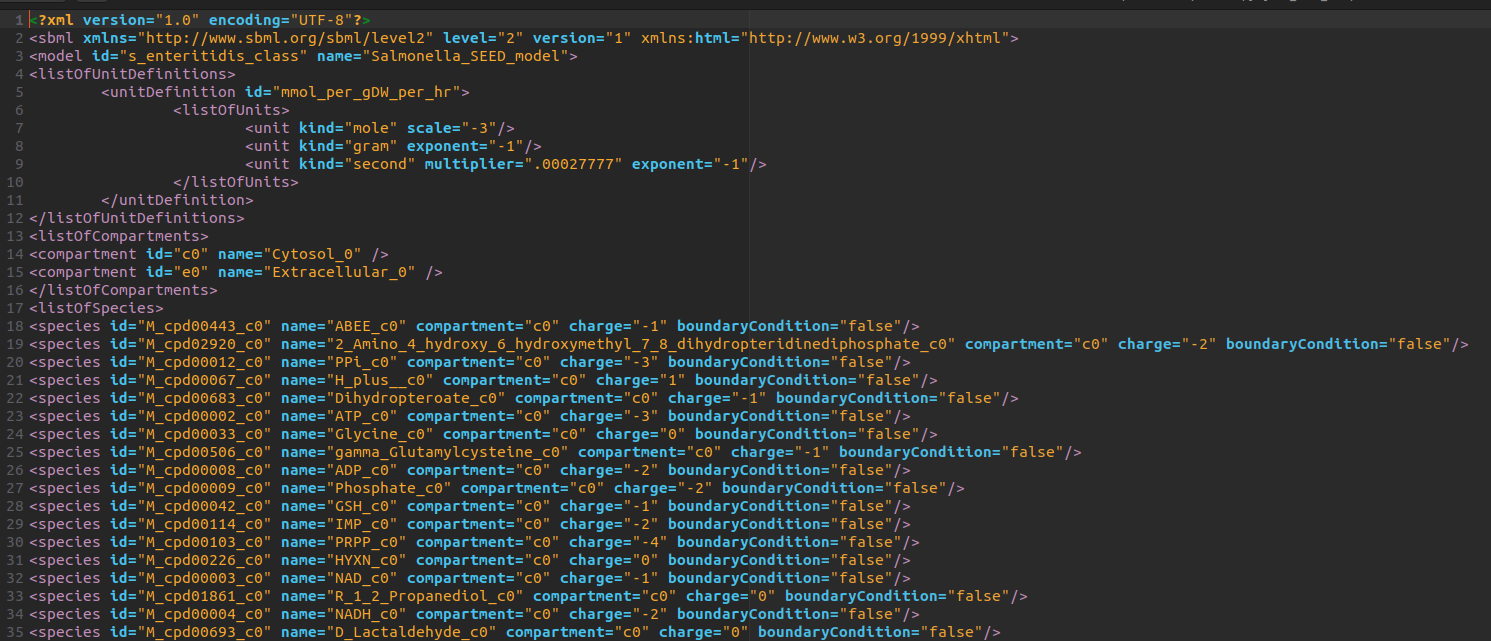

Once the script is complete, you will have a model in the `files/models/` folder that you can now load and use it with `cobra`. 

In [ ]:
bt_model = cobra.io.read_sbml_model("files/models/sugar_fermenter_toy_model.xml")
bt_model

So now, we have a model with several metabolites and reactions, which take place in both the cytosol (`c`) and out of the cell (`e`).

Also, there is an ***objective function***! 

Let's check on this!


In [ ]:
bt_model.reactions.biomass

> The extra mile
> 
> This step had a little cheat on our side, since there was no reason to already know which reaction is being used
> as the objective function. 
> And even if we would notice from the name that has something to do with the biomass, we do not know the actual id of the reaction.
> In an actual GEM, to make sure which is the reaction used as the objective function of the model, you would have to check the coefficients of each reaction in the objective function vector
> obj_index = [r.objective_coefficient for r in model.reactions].index(True)
> 

In [ ]:
# Getting the reaction id of the objective function in an actual case 
obj_index = [r.objective_coefficient for r in bt_model.reactions].index(True)
bt_model.reactions[obj_index].id

So, what is interesting besides the stoichiometry of the biomass reaction, indicating what compounds are required for biomass to be produced, and also what compounds are being produced, is that there is a **lower** and an **upper bound** in the `Reaction` object.

These values are **essential** for the model as they are those implying its constraints. 

For the biomass function you can see that there is a lower bound of 0 indicating that the model cannot have a negative flux for biomass, i.e. consume biomass, while the upper bound can be considered free, since it gets an extreme high value.

The total list of the **exchange** reactions present in a model, reaction objects for the metabolites that could **potentially be exchanged** (in or out), are available by running:

In [ ]:
bt_model.exchanges

Likewise, we can get the **sink** reactions:

In [ ]:
bt_model.sinks

While, we can also get all the boundary reactions together

In [ ]:
bt_model.boundary

However, only if a metabolite is available in the `medium` of the model can be actually used. 
`medium` contains the information about the concentration of metabolites that are available to the model from the external compartment (media metabolites).


In [ ]:
bt_model.medium

For a human readable version of the same information, one may run:

In [ ]:
for rxn in bt_model.medium:
    cobra_rxn = bt_model.reactions.get_by_id(rxn)
    cobra_met = cobra_rxn.metabolites
    print("reaction string:", cobra_rxn.build_reaction_string(), "metabolites:", [x.name for x in cobra_met])

#### Metabolites
A list that contains an object for each metabolite in the model.

There are different functions to retrieve the desired metabolite object from the model, according to some query criteria:

`model.metabolites.get_by_id` , `model.metabolites.get_by_any`, `model.metabolites.has_id`

The most important attributes of a metabolite object are:

- id - allows one to access the model object.


In [ ]:
water = bt_model.metabolites.cpd00001_c
water

if the database used contains ids that are not suitable as python variable names (such as the BIGG ids), the metabolite can be accessed with the `get_by_id` function of the `model.metabolites` object.


In [ ]:
water = bt_model.metabolites.get_by_id('cpd00001_c') #same result as above
water

Some attributes of the `metabolite` object

In [ ]:
#name
print('name: ', water.name)

#formula
print('formula: ', water.formula)

#elements
print('elements: ', water.elements)

#charge
print('charge: ', water.charge)

#compartment (The metabolite ids commonly have a '_c' or '_e' as a suffix, to indicate their compartments)
print('compartment: ', water.compartment)

#reactions (reaction objects where the metabolite is either a reactant or a product)
print('reactions: ', water.reactions)

#### Reactions
Also an attribute of the model object. Consists of a list containing a reaction object for each of the model's reactions.

In [ ]:
#number of reactions in the model
print(len(bt_model.reactions))

In [ ]:
for r in bt_model.reactions:
    print(r.id, r.build_reaction_string(use_metabolite_names=1))

Similar to the metabolite objects, reaction objects may be accessed directly by their ids or with the special functions:


`model.reactions.get_by_id` , `model.reactions.get_by_any`, `model.reactions.has_id`


In [ ]:
acetate_ptransferase = bt_model.reactions.rxn00225
print(acetate_ptransferase)
acetate_ptransferase = bt_model.reactions.get_by_id('rxn00225')
print(acetate_ptransferase)

Relevant attributes of the reaction object:

In [ ]:
#name
print('name:', acetate_ptransferase.name, '\n')

#compartments (while metabolites are present on a single compartments, reactions may occur across compartments)
print('compartments: ', acetate_ptransferase.compartments, '\n')

#metabolites
print('metabolites: ', acetate_ptransferase.metabolites)
print([i.name for i in acetate_ptransferase.metabolites], '\n')

#reactants
print('reactants: ', acetate_ptransferase.reactants)
print([i.name for i in acetate_ptransferase.reactants], '\n')

#products
print('products: ', acetate_ptransferase.products)
print([i.name for i in acetate_ptransferase.products], '\n')

#reaction
print('reaction: ', acetate_ptransferase.reaction, '\n')

#other ways to see the reaction
print(acetate_ptransferase.build_reaction_string())

print(acetate_ptransferase.build_reaction_string(use_metabolite_names=1))



In [ ]:
#see the details of the metabolic reactions containing the metabolite
for i in water.reactions:
  print(i.id, '\t', i.build_reaction_string(use_metabolite_names=True), '\n')

Notice that the `reaction.metabolites` object returns a python dictionary where the keys are the metabolite objects that participate in the reactions and the values are their stoichiometries. Reactants and products have, respectively, negative and positive values.

Since this is a constraint-based model, reactions also have lower and upper bounds, which constraint the fluxes. Through these bounds we may cotrol the direction of the reaction.

In [ ]:
print('lower bound: ', acetate_ptransferase.lower_bound, '\n')

print('upper bound: ', acetate_ptransferase.upper_bound, '\n')

print('biderectional reaction: ', acetate_ptransferase.build_reaction_string(use_metabolite_names=1), '\n')

#set the lower bound to zero
acetate_ptransferase.lower_bound = 0


print('irreversible reaction: ', acetate_ptransferase.build_reaction_string(use_metabolite_names=1))

##### Types of reactions

We can distinguish reactions based on the compartments of their metabolites


- Internal

Reactions that occur only in the cytosol. E.g.:

In [ ]:
ldh = bt_model.reactions.rxn00499
ldh

- Transport

Reactions that take extracellular metabolites and transport them into the cell (i.e. convert them into cytosol metabolites)

In [ ]:
gluT = bt_model.reactions.rxn05573

print(gluT.build_reaction_string(use_metabolite_names=True))
print(gluT.build_reaction_string(use_metabolite_names=False))

print(gluT.upper_bound)

print(gluT.lower_bound)

#Notice that 'cpd00027_e' is converted to 'cpd00027_c'.

- Exchange

Reactions that make a metabolite available in the extracellular space. From the extracellular space it can be taken up by a transporter.

In [ ]:
print([i.id for i in bt_model.exchanges])

gluExch = bt_model.reactions.EX_cpd00027_e

print(gluExch.build_reaction_string(use_metabolite_names=1))

print(gluExch.lower_bound)

print(gluExch.upper_bound)

# Notice that the inward flux is negative. If the flux is positive, it means the metabolite is getting secreted.

- Sink

Reactions that eliminate a dead-end metabolite (i.e. a metabolite that is not consumed by any further reaction and is not secreted)

In [ ]:
piSk = bt_model.reactions.piSink

print(piSk.build_reaction_string(use_metabolite_names=1))

print(piSk.lower_bound)

print(piSk.upper_bound)

- Objective

Based on the `objective coefficient`, we can obtain the reaction that is 'maximized' (or minimized) by the model.

In [ ]:
for i in bt_model.reactions:
    if i.objective_coefficient==1:
        print(i.id)

### GEM reconstruction standards

We were able to come up with a model in less than 40 minutes.
However, a model needs to be considered as a knowledge-base that can be improved in several ways.

To validate your model and to keep track of its versions you can use [MEMOTE](https://memote.io).

For the sake of time we will skip this part.

The [Systems Biology Markup Language (SBML)](https://sbml.org), is a free and open data format for computational systems biology that’s used by thousands of people worldwide.





## Constraint-based modeling


In our model, we consider the exchange pseudo reactions and assume a **steady state condition**, meaning that there is no accumulation or depletion of compounds; thus, the **rate of production equals the rate of
consumption for each compound** in the network; mass (and energy) is conserved. 

This can be mathematically described by: 

$$ 
S v = 0
$$

where $v$ represents the **flux vector**, a vector with the flux values of each and every reaction in the model.


Constraints however are represented in two ways:

- as **equations** that balance reaction inputs and outputs, and 
- as **inequalities** that impose bounds on the system. 

Let's have a look on what a constraint looks like! 

Let's think of a case where we have a case like the one in the figure above, 
where 

$$ A + B \rightarrow C $$

It's easy for one to guess that the production of $C$ is **constrained** by the reactions providing $A$ and those providing $B$. 
Thus, by the **bounds** of their production. 

Usign the `samples_in_constrain_3D` function, we can visualize this to better understand it.
We need to set the **bounds** of each of the reactions included and a relationship of 

> **Attention!**
> 
> In our implementation you need to give positive boundaries for all three reactions. 
> In an actual model, uptakes are usually handled with negative flux values.



In [ ]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# This should pop up on a new tab on your browser
samples_in_constraint_3D(
    r1_bounds = [5, 10],
    r2_bounds = [5, 10],
    r3_bounds = [0,  40],
    r3_relationship = [-1, -1]
)


Next, we demonstrate some of the basic functionalities of cobrapy. After this introduction, you should be able to:

1) Load a model object;
    &nbsp;

2) Manipulate metabolite, reaction, and gene objects;
    &nbsp;

3) Solve the model with linear programing, using flux balance analysis (FBA);
    &nbsp;

4) Change the composition of the external environment.
&nbsp;
&nbsp;

**Note**: in this tutorial we often refer to 'objects' such as 'model object', 'reaction object', etc. These are python classes, which contain a number of specific attributes.

#### Solving the model

We can solve the model using flux balance analysis, which maximizes the objective function (usually biomass). This means obtaining the maximum flux value that is allowed to run through our objective function (referred to as the "objective value"). This also gives a solution for the optimal flux of each reaction.


In [ ]:
obj = bt_model.optimize()

print(obj.objective_value)
print("--")
print(obj.fluxes)

For algorithms that require the objective_value in a fast way, use:



In [ ]:
objCoef = bt_model.slim_optimize()
objCoef

In [ ]:
#flux (only accessible after the model is solved)
print('optimal flux: ', acetate_ptransferase.flux)

In [ ]:
#"knock out" a reaction from the model
acetate_ptransferase.lower_bound = 0
acetate_ptransferase.upper_bound = 0

#force flux through a reaction (usually results in an infeasible model)
acetate_ptransferase.upper_bound = 1000
acetate_ptransferase.lower_bound = 10

In [ ]:

# # ---- GIVEN A GUROBI MODEL -----
# # Find blocked and essential reactions in subset (finds all if FVA is used)
# blocked = set()
# essential = set()
# for v in model.getVars():
#     b = v.lb, v.ub
#     if v in subset:
#         if not np.any(b):
#             blocked.add(v)
#         elif np.all(b) and len(set(np.sign(b))) == 1:
#             essential.add(v)


## A walk through the solution of the FBA

To better understand how constraints define the flux values of an FBA, but also what these fluxes mean for the cell's functions, 
we will use the [Escher online tool](https://sbrg.github.io/escher-fba/#/app) to have a better look at those and to their dynamics. 

Points to notice:

- Is **directionality** always clear ? How could we determine what the model actually suggests about the flux of a reversible reaction ?
- How you interpret the color coding ? What is the meaning of a red flux ? Are those the limiting factors of the model ? 
- What happens if you change the flux of a reaction ? Try for example `glc__D_e` and `PDH`. Do you notice anything on the range of the values the last may get ?



### Flux Variability Analysis

Returns minimum and maximum a flux may get respecting the constraints of the model.

**Remember**

When $v{_i}$ gets a value $x$, $v{_j}$ might need to get specific value $y$, so the system remains at steady state. 

FVA returns **ranges**, not **solutions**.


In [ ]:
modelFolder = os.path.join(os.getcwd(), "files", "models")
ecoli  =  cobra.io.read_sbml_model(os.path.join(modelFolder,'e_coli_core.xml' ))
cobra.flux_analysis.flux_variability_analysis(ecoli)

Let's have a look on the envelope ; built using `fluxpy` -- still in development 

## Sampling the solution space of metabolic models

While FBA finds a single maximum for the objective function, one might be interested in the space of viable metabolisms. This space reveals the range of conditions where the cell could live without the assumption of maximizing an objective function.

The space of viable metabolisms is explored by taking uniform samples from the flux distribution. Besides revealing the cell's metabolic potential, these samples also reveal the conformations of higher likelihood and the burden of regulation needed for the cell to achieve its "maximum growth". In the example below, we compare the point of optimal growth with alternative flux distributions.

In [ ]:
# import the necessary packages and functions
from cobra.sampling import ACHRSampler

#for making the plots
import matplotlib.pyplot as plt
# plt.style.use('seaborn-bright')


**step 2** : load the model, apply the rich media

In [ ]:
model_sf = cobra.io.read_sbml_model(os.path.join(modelFolder,'sugar_fermenter_toy_model.xml' ))


print("Initia medium:", model_sf.medium)
print("Total potential exchange reactions:", model_sf.exchanges)

rich_media = {'EX_cpd00027_e':10,
         'EX_cpd00036_e':10,
         'EX_cpd00159_e':10,
         'EX_cpd00047_e':10,
         'EX_cpd00029_e':10,
         'EX_cpd00067_e':10
         }

apply_environment(model_sf, rich_media)
print(model_sf.medium)

**step 3**: perform sampling

In [ ]:
sol = model_sf.optimize()
z = sol.objective_value #the objective value

#reaction fluxes under the optimal solution
glycolysis = model_sf.reactions.rxn00459.flux
fp = model_sf.reactions.EX_cpd00047_e.flux #formate production
lp = model_sf.reactions.EX_cpd00159_e.flux #lactate production
sp = model_sf.reactions.EX_cpd00036_e.flux #succinate production

achr = ACHRSampler(model_sf, thinning=10) #see https://cobrapy.readthedocs.io/en/latest/sampling.html
s1 = achr.sample(5000) #samples
v = achr.validate(s1)
sample = s1[v=='v'] #keep only the feasible samples

**step 4**: make plots

In [ ]:
fig, ax = plt.subplots()

#sampled biomass vs the sampled glycolysis
ax.scatter(sample.biomass, sample.rxn00459, s=0.1, color='#add8e6', alpha=0.5)

#optimal biomass vs the optimal glycolysis
ax.scatter(sol.objective_value, glycolysis, s=80, color='#add8e6', label = 'Glycolysis', edgecolors='k')

#sampled biomass vs the sampled formate production
ax.scatter(sample.biomass, sample.EX_cpd00047_e, s=0.1, color='purple', alpha=0.5)

#optimal biomass vs the optimal formate production
ax.scatter(sol.objective_value, fp, s=80, color='purple', label = 'Formate prod', edgecolors='k')

#sampled biomass vs the sampled succinate production
ax.scatter(sample.biomass, sample.EX_cpd00036_e, s=0.1, color='orange', alpha=0.5)

#optimal biomass vs the optimal succinate production
ax.scatter(sol.objective_value, sp, s=80, color='orange', label = 'Succinate prod', edgecolors='k')

#sampled biomass vs the sampled lactate production
ax.scatter(sample.biomass, sample.EX_cpd00159_e, s=0.1, color='#00ff9f', alpha=0.5)

#optimal biomass vs the optimal lactate production
ax.scatter(sol.objective_value, lp, s=80, color='#00ff9f', label = 'Lactate prod', edgecolors='k')

ax.set_ylabel('Flux', fontsize=14)
ax.set_xlabel('Biomass flux', fontsize=14)
plt.legend(fontsize='large', fancybox=True, title='Carb. Ferm.', title_fontsize='x-large', loc=2)
plt.xlim(0,z+1)



## Dynamic Flux Balance Analysis

**step 1**: import packages and load models


In [ ]:
from scipy.integrate import solve_ivp as solver
import matplotlib.pyplot as plt
# plt.style.use('seaborn-bright')


model_ac = cobra.io.read_sbml_model(os.path.join(modelFolder,'acetogen_toy_model.xml' ))
model_sf = cobra.io.read_sbml_model(os.path.join(modelFolder,'sugar_fermenter_toy_model.xml' ))
model_bp = cobra.io.read_sbml_model(os.path.join(modelFolder,'butyrate_producer_toy_model.xml' ))


**step 2**: define parameters and initial states

**Parameters**

| parameter | variable | default value |
| --------- | -------- | ------------- |
| acetogen glucose Monod K | ac_glucose_k | 1.0 |
| acetogen glucose yield | ac_glucose_y | 1.0 |
| acetogen formate Monod K | ac_for_k | 10.0 |
| acetogen formate yield | ac_for_y | 1.0 |
| acetogen CO2 Monod K | ac_co2_k | 1.0 |
| acetogen CO2 yield | ac_co2_y | 10.0 |
| acetogen H2 Monod K | ac_h2_k | 10.0 |
| acetogen H2 yield | ac_h2_y | 10.0 |
| acetogen acetate yield | ac_ac_y | -1.0 |
| acetogen lactate yield | ac_lac_y | -1.0 |
| sugarF glucose Monod K | sf_glucose_k | 1.0 |
| sugarF glucose yield | sf_glucose_y | 1.0 |
| sugarF succinate yield | sf_succ_y | -1.0 |
| sugarF formate yield | sf_for_y | -1.0 |
| sugarF lactate yield | sf_lac_y | -1.0 |
| sugarF acetate yield | sf_ac_y | -1.0 |
| butyrateP glucose Monod K | bp_glucose_k | 1.0 |
| butyrateP glucose yield | bp_glucose_y | 1.0 |
| butyrateP lactate consumpation Monod K | bp_lactate_c_k | 1.0 |
| butyrateP lactate consumption yield | bp_lactate_c_y | 1.0 |
| butyrateP lactate production yield | bp_lactate_p_y | -1.0 |
| butyrateP acetate consumpation Monod K | bp_acetate_c_k | 1.0 |
| butyrateP acetate consumption yield | bp_acetate_c_y | 1.0 |
| butyrateP acetate production yield | bp_acetate_p_y | -1.0 |
| butyrateP CO2 production yield | bp_co2_y | -1.0 |
| butyrateP H2 production yield | bp_h2_y | -1.0 |
| butyrateP butyrate production yield | bp_butyrate_y | -1.0 |
| flow rate | flow_rate | 0.1 |


**States**

| state | position | default value |
| ----- | -------- | ------------- |
|glucose concentration | 0 | 10 |
|formate concentration | 1 | 0 |
|CO2 concentration | 2 | 0 |
|H2 concentration | 3 | 0 |
|acetate concentration | 4 | 0 |
|lactate concentration | 5 | 0 |
|succinate concentration | 6 | 0 |
|butyrate concentration | 7 | 0 |
|acetogen biomass | 8 | 0.1 |
|sugarF biomass | 9 | 0.1 |
|butyrateP biomass | 10 | 0.1 |



In [ ]:
parameters = {'ac_glucose_k' : 1.0,
              'ac_glucose_y' : 1.0,
              'ac_for_k' : 10.0,
              'ac_for_y' : 1.00,
              'ac_co2_k' : 1.0,
              'ac_co2_y' : 10.00,
              'ac_h2_k' : 10.0,
              'ac_h2_y' : 1.00,
              'ac_ac_y':-1.0,
              'ac_lac_y':-1.0,
              'sf_glucose_k':1.0,
              'sf_glucose_y':1.0,
              'sf_succ_y':-1.0,
              'sf_for_y':-1.0,
              'sf_lac_y':-1.0,
              'sf_ac_y':-1.0,
              'bp_glucose_k':1.0,
              'bp_glucose_y':1.0,
              'bp_lactate_c_k':1.0,
              'bp_lactate_c_y':1.00,
              'bp_lactate_p_y': -1,
              'bp_acetate_c_k':1.0,
              'bp_acetate_c_y':1.0,
              'bp_acetate_p_y':-1,
              'bp_co2_y': -1,
              'bp_h2_y':-1,
              'bp_butyrate_y':-1,
              'flow_rate':0.1
              }

initial_states = np.array([10, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.1, 0.1])
#glc_S0, for_S0, co2_S0, H2_S0, acetate_S0, lac_S0, succ_S0, but_S0, ac_X0, sf_X0, bp_X0


**step 3**: write growth rate functions ($\mu$) for each bacteria

In [ ]:
def muAc(concentration_vec):
    '''
    growth rate function for the acetogen

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_formate
    consumed_co2
    consumed_h2
    produced_acetate
    produced_lactate
    objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['ac_glucose_k']))*(concentration_vec[0]>0)
    #(concentration_vec[0]>0) avoids negatives

    consumable_formate = (concentration_vec[1]/(concentration_vec[1]+parameters['ac_for_k']))*(concentration_vec[1]>0)

    consumable_co2 = (concentration_vec[2])/(concentration_vec[2]+parameters['ac_co2_k'])*(concentration_vec[2]>0)

    consumable_h2 = (concentration_vec[3])/(concentration_vec[3]+parameters['ac_h2_k'])*(concentration_vec[3]>0)

    #set the lower bounds to the consumable amounts

    model_ac.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    model_ac.reactions.EX_cpd00047_e.lower_bound = -1*consumable_formate
    model_ac.reactions.EX_cpd00011_e.lower_bound = -1*consumable_co2
    model_ac.reactions.EX_cpd11640_e.lower_bound = -1*consumable_h2

    #optimize with these consumable amounts as constraints

    sol_ac = model_ac.optimize()

    #get what was effectively consumed/produces
    consumed_glucose = max(0, model_ac.reactions.EX_cpd00027_e.flux*-1)
    consumed_formate = max(0, model_ac.reactions.EX_cpd00047_e.flux*-1)
    consumed_co2 = max(0, model_ac.reactions.EX_cpd00011_e.flux*-1)
    consumed_h2 = max(0, model_ac.reactions.EX_cpd11640_e.flux*-1)

    produced_acetate = max(0, model_ac.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, model_ac.reactions.EX_cpd00159_e.flux)

    return (consumed_glucose,
            consumed_formate,
            consumed_co2,
            consumed_h2,
            produced_acetate,
            produced_lactate,
            sol_ac.objective_value #the biomass given the consumable amounts
            )


def muSf(concentration_vec):
    '''

    Growth rate function for the sugarF

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    produced_acetate
    produced_lactate
    produced_succinate
    produced_formate
    objective_value

    '''



    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['sf_glucose_k']))*(concentration_vec[0]>0)

    model_sf.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose

    sol_sf = model_sf.optimize()

    consumed_glucose = max(0, model_sf.reactions.EX_cpd00027_e.flux*-1)

    produced_acetate = max(0, model_sf.reactions.EX_cpd00029_e.flux)
    produced_lactate = max(0, model_sf.reactions.EX_cpd00159_e.flux)
    produced_succinate = max(0, model_sf.reactions.EX_cpd00036_e.flux)
    produced_formate = max(0, model_sf.reactions.EX_cpd00047_e.flux)

    return (consumed_glucose,
            produced_acetate,
            produced_lactate,
            produced_succinate,
            produced_formate,
            sol_sf.objective_value
            )


def muBP(concentration_vec):
    '''
    Growth rate for the butyrate producer

    Parameters
    ----------
    concentration_vec :
        [glucose, formate, co2, h2, acetate, lactate, succinate, butyrate]

    Returns
    -------
    consumed_glucose
    consumed_acetate
    consumed_lactate
    produced_acetate
    produced_lactate
    produced_co2
    produced_h2
    produced_butyrate
    sol_bp.objective_value

    '''


    consumable_glucose = (concentration_vec[0]/(concentration_vec[0]+parameters['bp_glucose_k']))*(concentration_vec[0]>0)
    consumable_acetate = (concentration_vec[4]/(concentration_vec[4]+parameters['bp_acetate_c_k']))*(concentration_vec[4]>0)
    consumable_lactate = (concentration_vec[5]/(concentration_vec[5]+parameters['bp_lactate_c_k']))*(concentration_vec[5]>0)

    model_bp.reactions.EX_cpd00027_e.lower_bound = -1*consumable_glucose
    model_bp.reactions.EX_cpd00029_e.lower_bound = -1*consumable_acetate
    model_bp.reactions.EX_cpd00159_e.lower_bound = -1*consumable_lactate


    sol_bp = model_bp.optimize()
    consumed_glucose = max(0, model_bp.reactions.EX_cpd00027_e.flux*-1)
    consumed_acetate = 0
    produced_acetate = 0
    consumed_lactate = 0
    produced_lactate = 0

    #acetate was consumed instead of produced
    if model_bp.reactions.EX_cpd00029_e.flux<0:
        consumed_acetate = model_bp.reactions.EX_cpd00029_e.flux*-1

    #lactate was consumed instead of produced
    if model_bp.reactions.EX_cpd00159_e.flux<0:
        consumed_lactate = model_bp.reactions.EX_cpd00159_e.flux*-1


    #acetate was produced
    if model_bp.reactions.EX_cpd00029_e.flux>0:
        produced_acetate = model_bp.reactions.EX_cpd00029_e.flux

    #lactate was produced
    if model_bp.reactions.EX_cpd00159_e.flux>0:
        produced_lactate = model_bp.reactions.EX_cpd00159_e.flux


    produced_co2 = max(0, model_bp.reactions.EX_cpd00011_e.flux)
    produced_h2 = max(0, model_bp.reactions.EX_cpd11640_e.flux)
    produced_butyrate = max(0, model_bp.reactions.EX_cpd00211_e.flux)

    return (consumed_glucose,
            consumed_acetate,
            consumed_lactate,
            produced_acetate,
            produced_lactate,
            produced_co2,
            produced_h2,
            produced_butyrate,
            sol_bp.objective_value
            )



**Step 4**: define the ordinary differential equation (ODE) that updates the states (see the table containing the 11 states above)

In [ ]:
def ode(t, states):

    '''
    ODE
    states:
        [glc_S0, for_S0, co2_S0, H2_S0, acetate_S0, lac_S0, succ_S0, but_S0, ac_X0, sf_X0, bp_X0]
    '''

    #get the metabolite consumption/production and instantaneous growth rates
    mu_ac = muAc(states)
    mu_sf = muSf(states)
    mu_bp = muBP(states)

    #get the current biomasses
    pop_ac = states[8]
    pop_sf = states[9]
    pop_bp = states[10]

    #change in the acetogen biomass
    dAc = (pop_ac* mu_ac[-1])-parameters['flow_rate']*pop_ac

    #change in the sugarF biomass
    dSf = (pop_sf* mu_sf[-1]) - parameters['flow_rate']*pop_sf

    #change in the butyrateP biomass
    dBp = (pop_bp*mu_bp[-1])- parameters['flow_rate']*pop_bp

    #acetogen metabolite consumption/production
    ac_glc = -(mu_ac[0]/parameters['ac_glucose_y'])*pop_ac
    ac_for = -(mu_ac[1]/parameters['ac_for_y'])*pop_ac
    ac_co2 = -(mu_ac[2]/parameters['ac_co2_y'])*pop_ac
    ac_h2 = -(mu_ac[3]/parameters['ac_h2_y'])*pop_ac
    ac_ac = -(mu_ac[4]/parameters['ac_ac_y'])*pop_ac
    ac_lac = -(mu_ac[5]/parameters['ac_lac_y'])*pop_ac

    #sugarF metabolite consumption/production
    sf_glc = -(mu_sf[0]/parameters['sf_glucose_y'])*pop_sf
    sf_ac = -(mu_sf[1]/parameters['sf_ac_y'])*pop_sf
    sf_lac = -(mu_sf[2]/parameters['sf_lac_y'])*pop_sf
    sf_succ = -(mu_sf[3]/parameters['sf_succ_y'])*pop_sf
    sf_for = -(mu_sf[4]/parameters['sf_for_y'])*pop_sf

    #butyrateP metabolite consumption/production
    bp_glc = -(mu_bp[0]/parameters['bp_glucose_y'])*pop_bp
    bp_ac_c = -(mu_bp[1]/parameters['bp_acetate_c_y'])*pop_bp
    bp_lac_c = -(mu_bp[2]/parameters['bp_lactate_c_y'])*pop_bp

    bp_ac_p = -(mu_bp[3]/parameters['bp_acetate_p_y'])*pop_bp
    bp_lac_p = -(mu_bp[4]/parameters['bp_lactate_p_y'])*pop_bp
    bp_co2_p = -(mu_bp[5]/parameters['bp_co2_y'])*pop_bp
    bp_h2_p = -(mu_bp[6]/parameters['bp_h2_y'])*pop_bp
    bp_but_p = -(mu_bp[7]/parameters['bp_butyrate_y'])*pop_bp


    derivatives = np.zeros(len(states))

    #glucose
    derivatives[0] = parameters['flow_rate']*initial_states[0] + ac_glc + sf_glc + bp_glc - parameters['flow_rate']*states[0]

    #formate
    derivatives[1] = parameters['flow_rate']*initial_states[1] + ac_for + sf_for  - parameters['flow_rate']*states[1]

    #co2
    derivatives[2] = parameters['flow_rate']*initial_states[2] + ac_co2 + bp_co2_p  - parameters['flow_rate']*states[2]

    #h2
    derivatives[3] = parameters['flow_rate']*initial_states[3] + ac_h2 + bp_h2_p  - parameters['flow_rate']*states[3]

    #acetate
    derivatives[4] = parameters['flow_rate']*initial_states[4] + ac_ac + sf_ac + bp_ac_c + bp_ac_p  - parameters['flow_rate']*states[4]

    #lactate
    derivatives[5] = parameters['flow_rate']*initial_states[5] + ac_lac + sf_lac + bp_lac_c + bp_lac_p  - parameters['flow_rate']*states[5]

    #succinate
    derivatives[6] = parameters['flow_rate']*initial_states[6] + sf_succ  - parameters['flow_rate']*states[6]

    #butyrate
    derivatives[7] = parameters['flow_rate']*initial_states[7] + bp_but_p  - parameters['flow_rate']*states[7]

    derivatives[8] = dAc
    derivatives[9] = dSf
    derivatives[10] = dBp

    return derivatives


**Step 5**: solve the initial value problem for the ODE

In [ ]:
solution = solver(fun=ode, t_span = (0, 800), y0 = initial_states, t_eval = np.linspace(0, 800, 1000))

**Step 6**: plot the results for the biomass

In [ ]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[8], color='g', label='acetogen')
ax.plot(solution.t, solution.y[9], color='b', label='carb ferm')
ax.plot(solution.t, solution.y[10], color='r', label='but prod')
ax.set_ylabel('Biomass')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
plt.show()

**Step 7**: plot the results for the metabolites

In [ ]:
fig, ax = plt.subplots()

ax.plot(solution.t, solution.y[0], color='#0776c0', label='Glucose')

ax.plot(solution.t, solution.y[4], color='#db571a', label='Acetate')

ax.plot(solution.t, solution.y[1], color='#edb320', label='Formate')

ax.plot(solution.t, solution.y[2], color='#7e2c8d', label='CO2')
ax.plot(solution.t, solution.y[3], color='#7e2c8d', label='H2')

ax.plot(solution.t, solution.y[5], color='#00ff9f', label='Lactate')
ax.plot(solution.t, solution.y[6], color='#32CD32', label='Succinate')
ax.plot(solution.t, solution.y[7], color='#001eff', label='Butyrate')


ax.set_ylabel('Concentration')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Tasks

### Model manipulation (Level 1)



Make a summary table containing all the reactions in the toy models with the following fields:

- Id

- Name
- Reaction string with metabolite names
- Lower bound
- Upper bound
- Reversibility
- Type (internal, objective, transport, sink, exchange)
- SugarFermenter (1 if present in the sugar fermenter, 0 otherwise)
- ButyrateProducer (1 if present in the butyrate producer, 0 otherwise)
- Acetogen (1 if present in the acetogen, 0 otherwise)


#### genes

The model object also contais genes.


In [ ]:
# change to the 'full' model
import os
modelFolder = os.path.join(os.getcwd(), "files", "models")
model = cobra.io.read_sbml_model(os.path.join(modelFolder,'e_coli_core.xml' ))


print(model.genes)

gene1 = model.genes[0]

print('name: ', gene1.name, '\n')

print('id: ', gene1.id, '\n')

print('reactions:', gene1.reactions)
print([i.name for i in gene1.reactions])

Note that a single gene can explain several reactions and a reaction may be explained by one or more genes. Boolean rules may be applied to explain if the reaction is an isozyme (OR) or part of a complex (AND).

In [ ]:
for i in gene1.reactions:
    print(i.gene_reaction_rule)

Gapfilled reactions and some others (sink, exchange) do not have genes associated to them:

In [ ]:
geneless = [i.id for i in model.reactions if i.genes == frozenset()]

print(geneless)

note the toy models do not contain any genes associated to them.

In [ ]:
model = cobra.io.read_sbml_model(os.path.join(modelFolder,'acetogen_toy_model.xml' ))

print(len(model.genes))

### Model manipulation (Level 2)

- Find reactions that are essential for the model to produce biomass (pick any of the toy models)

- Find reactions that are only essential in pairs

- Repeat the above, but now find reaction and reaction pairs that reduce the model’s biomass by up to an arbitrary threshold (i.e. 10%)

- **bonus task**: find a metabolite-set that is always essential for your picked model to grow.

#### Changing the environment

The metabolites are made available to the models through the exchange reactions (see above).

To 'control' the composition, set the lower bound. But take into account that these are constrained-based models. To 'force' the models to consume a defined amount, set the lower and upper bound to this amount (this often leads to unfeasible models)

In [ ]:
# provide a rich media
for i in model.exchanges:
    i.lower_bound = -1000

obj = model.optimize()

print('rich media: ', obj.objective_value, '\n')


# remove glucose
model.reactions.EX_cpd00027_e.lower_bound=0

obj = model.optimize()

print('no glucose: ', obj.objective_value, '\n')

# force a glucose flux

model.reactions.EX_cpd00027_e.lower_bound=-30
model.reactions.EX_cpd00027_e.upper_bound=-30
obj = model.optimize()

print('forced glucose flux: ', obj.objective_value, '\n')

print('glucose flux: ',
model.reactions.EX_cpd00027_e.flux)


In [ ]:
model.medium

### Model manipulation (Level 3)

- Generate random environment compositions and associate them to the production of biomass by the three toy models

- Compare their growth rate distributions across these random environments (making box plots should be enough)

- Make the same comparison without glucose

- **bonus task**: repeat the above in an environment with a fixed high and low sugar concentration.
